# PeakAffectDS Analysis

### Load Libraries

Here we will load the relevant libraries needed to properly analyze the data. We will be using Pandas to load the data into dataframes.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import Data

In [17]:
happy = pd.read_csv('Data/Raw_PID_01-10/01/01-03-01.csv')
print('rows =', len(happy.index))
happy.head()

rows = 390568


,Time,EMG_zyg,EMG_cor,ECG,Respiration,Events
0,0.0005,-0.048828,-0.057068,-0.170288,-0.065918,0.0
1,0.0010,-0.031433,-0.043030,-0.169067,-0.065308,0.0
2,0.0015,-0.002136,-0.024414,-0.169983,-0.065002,0.0
3,0.0020,0.030212,-0.003357,-0.172424,-0.064392,0.0
4,0.0025,0.040894,0.010681,-0.174866,-0.063782,0.0


### Plotting Data

Now we can use this data to make a power spectrum graph. Here, I will make a graph of the `EMG_zyg` column.

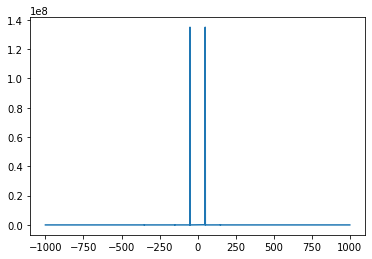

In [21]:
time_step = 0.0005
ps = np.abs(np.fft.fft(happy['EMG_zyg'])) ** 2
freqs = np.fft.fftfreq(happy['EMG_zyg'].size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])
ply.xlabel()

From this graph, we can see that there are massive spikes in the power at the 50 Hz range, as we might have expected